In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshulm257/rice-disease-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rice-disease-dataset' dataset.
Path to dataset files: /kaggle/input/rice-disease-dataset


In [4]:
import os

base_path = "/kaggle/input/rice-disease-dataset"
print(os.listdir(base_path))

['Rice_Leaf_AUG']


With preprocessing and augmentation


In [12]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

base_path = "/kaggle/input/rice-disease-dataset"
print(os.listdir(base_path))
data_dir = base_path + "/Rice_Leaf_AUG"

# Image Augmentation + Preprocessing
transform = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]),
}

# Auto split train/test
dataset = datasets.ImageFolder(data_dir, transform["train"])

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Classes:", dataset.classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

['Rice_Leaf_AUG']
Classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']
Train samples: 3063
Test samples: 766


In [13]:
import os

folder = base_path + "/Rice_Leaf_AUG"
print(os.listdir(folder)[:20])


['Leaf scald', 'Sheath Blight', 'Healthy Rice Leaf', 'Leaf Blast', 'Brown Spot', 'Bacterial Leaf Blight']


In [14]:
import torch
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))  # number of classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


Device: cuda


In [15]:
from tqdm import tqdm

epochs = 10

train_losses = []
val_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    print(f"\nEpoch {epoch+1}/{epochs}")


    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)


    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.2f}, Accuracy: {epoch_acc:.2f}%")

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)

    print(f"Validation Loss: {val_loss:.2f}")


Epoch 1/10


Training Epoch 1: 100%|██████████| 96/96 [00:48<00:00,  1.99it/s]


Epoch 1, Loss: 0.77, Accuracy: 72.80%
Validation Loss: 0.40

Epoch 2/10


Training Epoch 2: 100%|██████████| 96/96 [00:42<00:00,  2.26it/s]


Epoch 2, Loss: 0.28, Accuracy: 91.12%
Validation Loss: 0.22

Epoch 3/10


Training Epoch 3: 100%|██████████| 96/96 [00:43<00:00,  2.22it/s]


Epoch 3, Loss: 0.16, Accuracy: 95.20%
Validation Loss: 0.15

Epoch 4/10


Training Epoch 4: 100%|██████████| 96/96 [00:42<00:00,  2.24it/s]


Epoch 4, Loss: 0.10, Accuracy: 97.16%
Validation Loss: 0.11

Epoch 5/10


Training Epoch 5: 100%|██████████| 96/96 [00:42<00:00,  2.28it/s]


Epoch 5, Loss: 0.06, Accuracy: 98.37%
Validation Loss: 0.09

Epoch 6/10


Training Epoch 6: 100%|██████████| 96/96 [00:42<00:00,  2.27it/s]


Epoch 6, Loss: 0.05, Accuracy: 98.63%
Validation Loss: 0.13

Epoch 7/10


Training Epoch 7: 100%|██████████| 96/96 [00:42<00:00,  2.24it/s]


Epoch 7, Loss: 0.04, Accuracy: 98.69%
Validation Loss: 0.10

Epoch 8/10


Training Epoch 8: 100%|██████████| 96/96 [00:43<00:00,  2.20it/s]


Epoch 8, Loss: 0.04, Accuracy: 99.22%
Validation Loss: 0.13

Epoch 9/10


Training Epoch 9: 100%|██████████| 96/96 [00:42<00:00,  2.24it/s]


Epoch 9, Loss: 0.04, Accuracy: 98.63%
Validation Loss: 0.11

Epoch 10/10


Training Epoch 10: 100%|██████████| 96/96 [00:41<00:00,  2.29it/s]


Epoch 10, Loss: 0.05, Accuracy: 98.50%
Validation Loss: 0.12


In [17]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Train Accuracy: {100 * correct / total:.2f}%")


Train Accuracy: 99.09%


In [16]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 95.95%


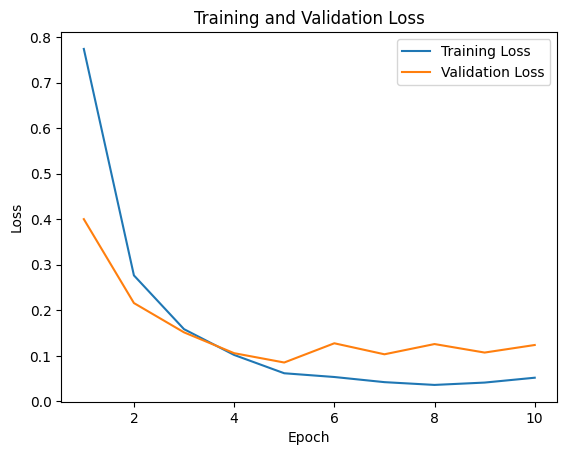

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

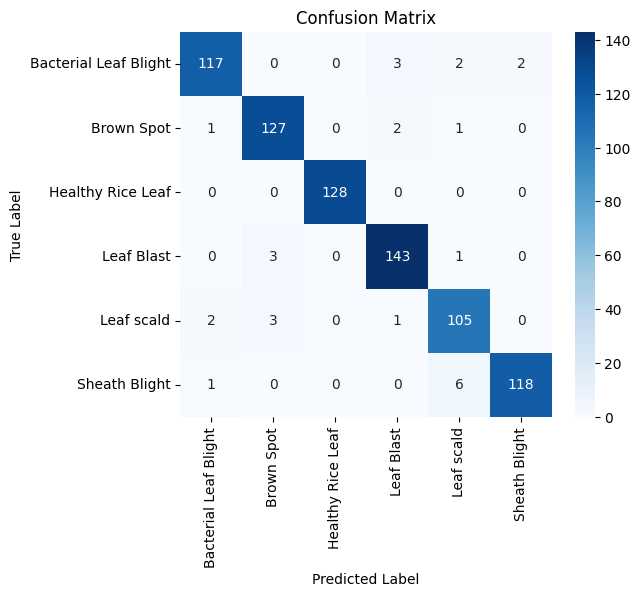

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=dataset.classes,
    yticklabels=dataset.classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
import os

print(os.listdir(data_dir))


['Leaf scald', 'Sheath Blight', 'Healthy Rice Leaf', 'Leaf Blast', 'Brown Spot', 'Bacterial Leaf Blight']


In [24]:
from PIL import Image

def predict_image(image_path):
    model.eval()

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return dataset.classes[predicted.item()]

In [25]:
import os

first_class = os.listdir(data_dir)[0]
class_path = os.path.join(data_dir, first_class)

first_image = os.listdir(class_path)[0]
image_path = os.path.join(class_path, first_image)

print("Testing:", image_path)
print("Prediction:", predict_image(image_path))


Testing: /kaggle/input/rice-disease-dataset/Rice_Leaf_AUG/Leaf scald/aug_0_5995.jpg
Prediction: Leaf scald
